<a href="https://colab.research.google.com/github/khall02/DS4-PH-2025/blob/main/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt


In [25]:
# Connect to the SQLite database- uploaded opioid.db to google colab, saved from Terminal
conn = sqlite3.connect("/content/opioid.db")


In [26]:
# Read tables into Pandas dataframes
county_pop_arcos = pd.read_sql_query("SELECT * FROM county_pop_arcos", conn)
land_area = pd.read_sql_query("SELECT * FROM land_area", conn)
county_annual = pd.read_sql_query("SELECT * FROM county_annual", conn)


In [27]:
conn.close()


In [28]:
# Look at data preview:
print(county_pop_arcos.head())
print(land_area.head())
print(county_annual.head())


   ? BUYER_COUNTY BUYER_STATE countyfips STATE COUNTY county_name  \
0  1      AUTAUGA          AL      01001     1      1     Autauga   
1  2      BALDWIN          AL      01003     1      3     Baldwin   
2  3      BARBOUR          AL      01005     1      5     Barbour   
3  4         BIBB          AL      01007     1      7        Bibb   
4  5       BLOUNT          AL      01009     1      9      Blount   

                      NAME    variable  year population  
0  Autauga County, Alabama  B01003_001  2006      51328  
1  Baldwin County, Alabama  B01003_001  2006     168121  
2  Barbour County, Alabama  B01003_001  2006      27861  
3     Bibb County, Alabama  B01003_001  2006      22099  
4   Blount County, Alabama  B01003_001  2006      55485  
   ?       Areaname  STCOU LND010190F  LND010190D LND010190N1 LND010190N2  \
0  1  UNITED STATES  00000          0  3787425.08        0000        0000   
1  2        ALABAMA  01000          0    52422.94        0000        0000   
2  3  

In [29]:
# Rename columns for consistency
county_pop_arcos.rename(columns={ "BUYER_STATE": "state", "population": "pop"}, inplace=True)
county_annual.rename(columns={"BUYER_COUNTY": "county_name", "BUYER_STATE": "state", "DOSAGE_UNIT": "opioid_pills"}, inplace=True)



In [30]:
# Split "Areaname" into county and state
land_area[["county_name", "state"]] = land_area["Areaname"].str.rsplit(", ", n=1, expand=True)


In [31]:
# Rename STCOU to countyfips for merging
land_area.rename(columns={"STCOU": "countyfips"}, inplace=True)


In [32]:
# `countyfips` is consistently formatted as a string
county_pop_arcos["countyfips"] = county_pop_arcos["countyfips"].astype(str)
land_area["countyfips"] = land_area["countyfips"].astype(str)
county_annual["countyfips"] = county_annual["countyfips"].astype(str)


In [33]:
# Merge datasets
df = county_pop_arcos.merge(land_area, on=["countyfips", "state"], how="left")
df = df.merge(county_annual, on=["countyfips", "year", "state"], how="left")


In [34]:
# Convert `year` to integer
df["year"] = df["year"].astype(int)


In [35]:
# Ensure numeric columns are converted properly
df["opioid_pills"] = pd.to_numeric(df["opioid_pills"], errors="coerce")
df["pop"] = pd.to_numeric(df["pop"], errors="coerce")



In [36]:
# calc opioid avg per person
df["opioid_pills_per_person"] = df["opioid_pills"] / df["pop"]


In [37]:
# Aggregate: average opioid pills per year
opioid_by_year = df.groupby("year")["opioid_pills_per_person"].mean().reset_index()

In [38]:
print(opioid_by_year.head())

   year  opioid_pills_per_person
0  2006                28.783799
1  2007                32.474087
2  2008                35.503895
3  2009                39.094975
4  2010                41.532509


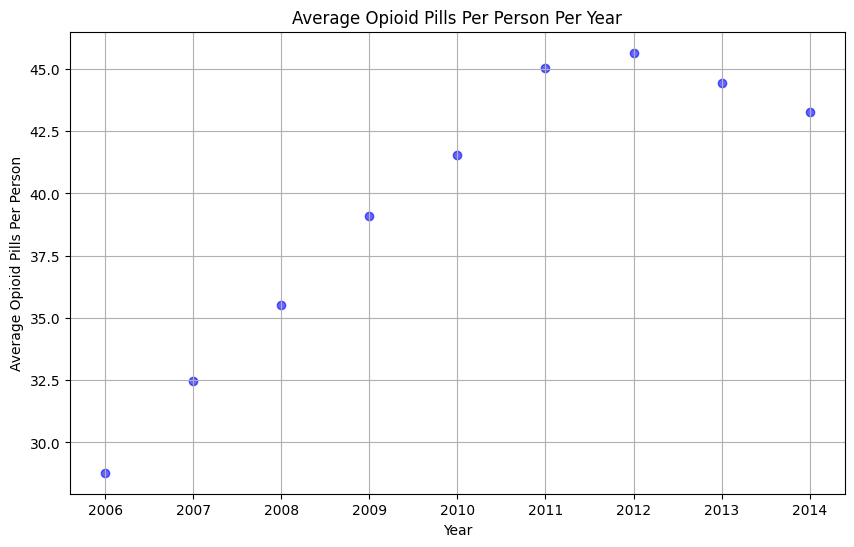

In [39]:
#Create a scatterplot of the average number of opiod pills by year by loading the sql database in python
plt.figure(figsize=(10, 6))
plt.scatter(opioid_by_year["year"], opioid_by_year["opioid_pills_per_person"], color='b', alpha=0.6)
plt.xlabel("Year")
plt.ylabel("Average Opioid Pills Per Person")
plt.title("Average Opioid Pills Per Person Per Year")
plt.grid(True)
plt.show()

In [90]:
#Take your R code from the previous step and call it from python instead of R. Convert the resulting dataset to a pandas dataframe.


import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

In [91]:
# Enable automatic conversion between R and pandas
pandas2ri.activate()



In [98]:
#Run the R script (loads df into R environment)
ro.r.source("hw4.R")


New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`


value,[19]
visible,[10]


In [101]:
r_df = ro.r['df']


In [102]:
# use r_df as a Pandas DataFrame
if isinstance(r_df, pd.DataFrame):
    opioid_df = r_df  # Already a Pandas DataFrame, no conversion needed
else:
    opioid_df = pandas2ri.rpy2py(r_df)  # Convert only if necessary


In [103]:
# Remove any unnamed columns (like `...1`)
opioid_df = opioid_df.loc[:, ~opioid_df.columns.str.contains(r'^\.\.\.\d+', regex=True)]


In [104]:
print(opioid_df.head())



  BUYER_COUNTY state countyfips  STATE  COUNTY county_name.x  \
1      AUTAUGA    AL      01001    1.0     1.0       Autauga   
2      BALDWIN    AL      01003    1.0     3.0       Baldwin   
3      BARBOUR    AL      01005    1.0     5.0       Barbour   
4         BIBB    AL      01007    1.0     7.0          Bibb   
5       BLOUNT    AL      01009    1.0     9.0        Blount   

                      NAME    variable  year       pop  ... LND210190N1  \
1  Autauga County, Alabama  B01003_001  2006   51328.0  ...        0000   
2  Baldwin County, Alabama  B01003_001  2006  168121.0  ...        0000   
3  Barbour County, Alabama  B01003_001  2006   27861.0  ...        0000   
4     Bibb County, Alabama  B01003_001  2006   22099.0  ...        0000   
5   Blount County, Alabama  B01003_001  2006   55485.0  ...        0000   

   LND210190N2  LND210200F LND210200D LND210200N1  LND210200N2  county_name  \
1         0000         0.0       8.48        0000         0000      AUTAUGA   
2     